## MODELO NO SUPERVISADO

In [1]:
# ========================
# 1. Importación de librerías y carga de datos
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn: Modelos y preprocesamiento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans

# Modelos adicionales: XGBoost, LightGBM y CatBoost
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Librerías para clustering
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../utils')))
from ClusteringPreprocessor import DataPreprocessor, ClusteringAndMapping

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ========================
# 2. Carga de los datos
# ========================

# Cargar datasets de entrenamiento y prueba
train_path = "../data/Train.csv"
test_path = "../data/Test.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Exploración inicial de los datos
print(" Información del dataset de entrenamiento:")
print(df.info())
print("\n Primeras filas del dataset de entrenamiento:")
print(df.head())

print("\n Información del dataset de test:")
print(test_df.info())
print("\n Primeras filas del dataset de test:")
print(test_df.head())

 Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None

 Primeras filas del dataset de entrenamiento:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healt


 Valores nulos en dataset de entrenamiento:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

 Valores nulos en dataset de test:
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


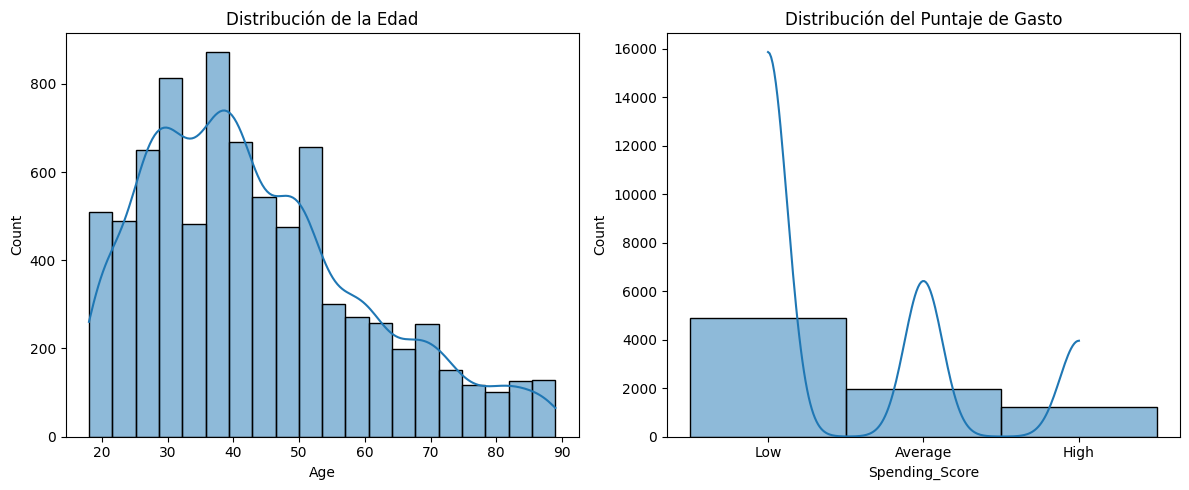

In [3]:
# ========================
# 3. Análisis de valores nulos y distribuciones
# ========================

# Verificar valores nulos en cada dataset
print("\n Valores nulos en dataset de entrenamiento:")
print(df.isnull().sum())

print("\n Valores nulos en dataset de test:")
print(test_df.isnull().sum())

# Visualización de la distribución de algunas variables clave
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Age'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribución de la Edad')

sns.histplot(df['Spending_Score'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribución del Puntaje de Gasto')

plt.tight_layout()
plt.show()

In [4]:
# ========================
# 4. Manejo de Valores Nulos y Transformaciones
# ========================

# Seleccionar las columnas para el preprocesamiento
numeric_features = ["Age", "Work_Experience", "Family_Size", "Spending_Score"]
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession"]

# Verificar valores nulos en los datasets antes de aplicar la pipeline
print("\n Valores nulos en el dataset de entrenamiento antes de imputar:")
print(df.isnull().sum())

print("\n Valores nulos en el dataset de test antes de imputar:")
print(test_df.isnull().sum())


 Valores nulos en el dataset de entrenamiento antes de imputar:
ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

 Valores nulos en el dataset de test antes de imputar:
ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
Segmentation         0
dtype: int64


In [5]:
# ========================
# 5. Preprocesador con Imputación de Valores Nulos
# ========================

# Transformaciones para variables numéricas y categóricas
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),  # Imputar valores nulos con la mediana
        ("scaler", StandardScaler())  # Escalar variables numéricas
    ]), numeric_features),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),  # Imputar valores nulos con el valor más frecuente
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Codificar variables categóricas
    ]), categorical_features)
])

# Seleccionar columnas categóricas
categorical_features = ["Gender", "Ever_Married", "Graduated", "Profession", "Var_1", "Segmentation"]

# Debug print
print("Original columns:", df.columns.tolist())

# 3. Preparar los datos para el clustering
X = df.drop(['ID', 'Segmentation'], axis=1)

# Debug print
print("Columns after dropping ID and Segmentation:", X.columns.tolist())

Original columns: ['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Segmentation']
Columns after dropping ID and Segmentation: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']


In [6]:
# ========================
# 6. Definir Pipeline de Clustering Mejorada
# ========================

pipeline_unsupervised = Pipeline(steps=[
    ('preprocessor', DataPreprocessor()),
    ('feature_selector', ColumnTransformer([
        ('num', StandardScaler(), ['Age', 'Work_Experience', 'Family_Size', 'Spending_Power']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), 
         ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Age_Group'])
    ])),
    ('clustering_mapping', ClusteringAndMapping(k_range=range(2, 8), random_state=42))
])

In [7]:
# ========================
# 7. Ajustar la Pipeline y Obtener Etiquetas de Clustering
# ========================

try:
    target_labels = pipeline_unsupervised.fit_transform(X)
    df["target"] = target_labels
    print("Clustering aplicado correctamente.")
except KeyError as e:
    print(f"KeyError encontrado: {e}")
    print("Columnas esperadas vs. columnas disponibles:")
    expected_cols = ["Age", "Work_Experience", "Family_Size", "Spending_Score", 
                     "Gender", "Ever_Married", "Graduated", "Profession"]
    available_cols = X.columns.tolist()
    print("Esperadas:", expected_cols)
    print("Disponibles:", available_cols)

Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']
Número óptimo de clusters encontrado: 6

 Mapping final de clusters: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Clustering aplicado correctamente.


Columns in input data: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']
Columns after preprocessing: ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1', 'Age_Group', 'Spending_Power']


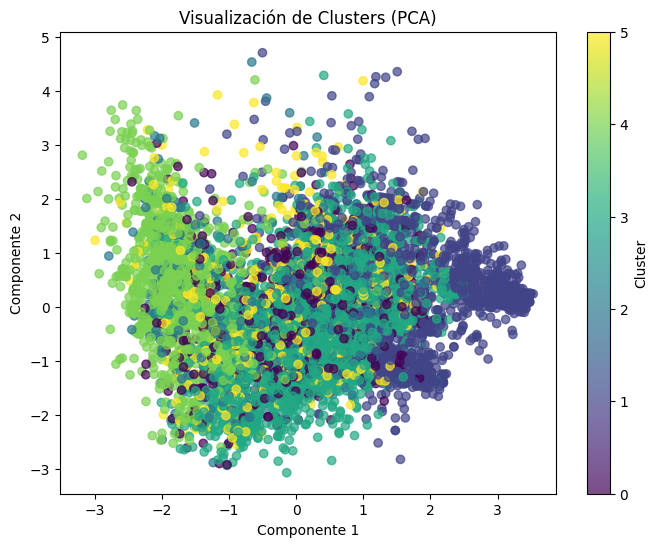

In [8]:
# ========================
# 8. Visualización de Clusters con PCA
# ========================

# Obtener los datos transformados
preprocessed_data = pipeline_unsupervised.named_steps["preprocessor"].transform(X)
feature_selected_data = pipeline_unsupervised.named_steps["feature_selector"].transform(preprocessed_data)

# Aplicar PCA para reducir dimensionalidad
pca = PCA(n_components=2)
components = pca.fit_transform(feature_selected_data)

# Obtener las etiquetas de los clusters
clusters = pipeline_unsupervised.named_steps["clustering_mapping"].best_model_.labels_

# Gráfico de dispersión con clusters
plt.figure(figsize=(8,6))
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("Visualización de Clusters (PCA)")
plt.colorbar(label="Cluster")
plt.show()

In [9]:
# ========================
# 10. Evaluación del Clustering con Silhouette Score
# ========================

from sklearn.metrics import silhouette_score

# Calcular el silhouette score con los datos transformados
silhouette_avg = silhouette_score(feature_selected_data, clusters)
print(f"\n Silhouette Score: {silhouette_avg:.3f}")


 Silhouette Score: 0.102



Cluster 0:
Tamaño: 914 clientes
Edad promedio: 43.1
Profesiones principales:
Profession
Entertainment    914
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.614880
Average    0.346827
High       0.038293
Name: proportion, dtype: float64

Cluster 1:
Tamaño: 1389 clientes
Edad promedio: 66.0
Profesiones principales:
Profession
Lawyer       611
Executive    558
Artist       156
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
High       0.584593
Low        0.302376
Average    0.113031
Name: proportion, dtype: float64

Cluster 2:
Tamaño: 683 clientes
Edad promedio: 37.0
Profesiones principales:
Profession
Doctor    683
Name: count, dtype: int64
Distribución de Gastos:
Spending_Score
Low        0.702782
Average    0.259151
High       0.038067
Name: proportion, dtype: float64

Cluster 3:
Tamaño: 2757 clientes
Edad promedio: 44.6
Profesiones principales:
Profession
Artist       2293
Homemaker     170
Marketing     104
Name: count, dtype: int64
Di

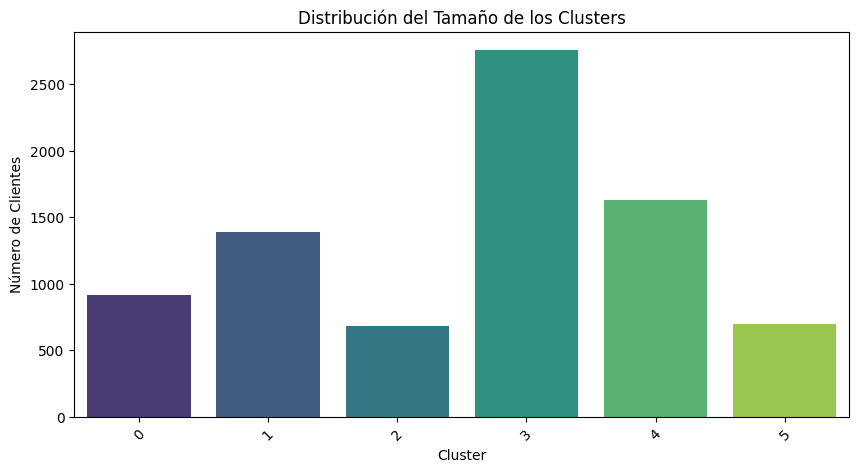

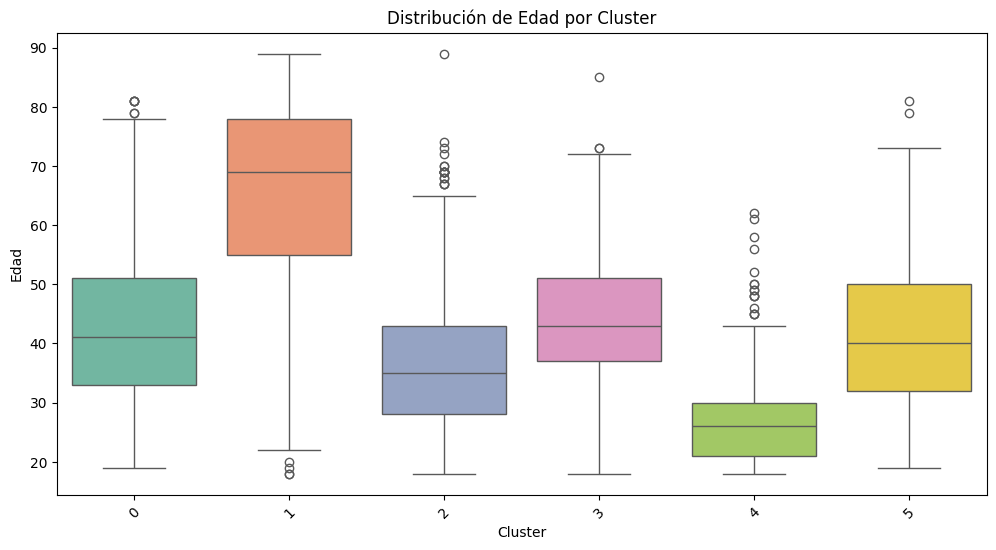

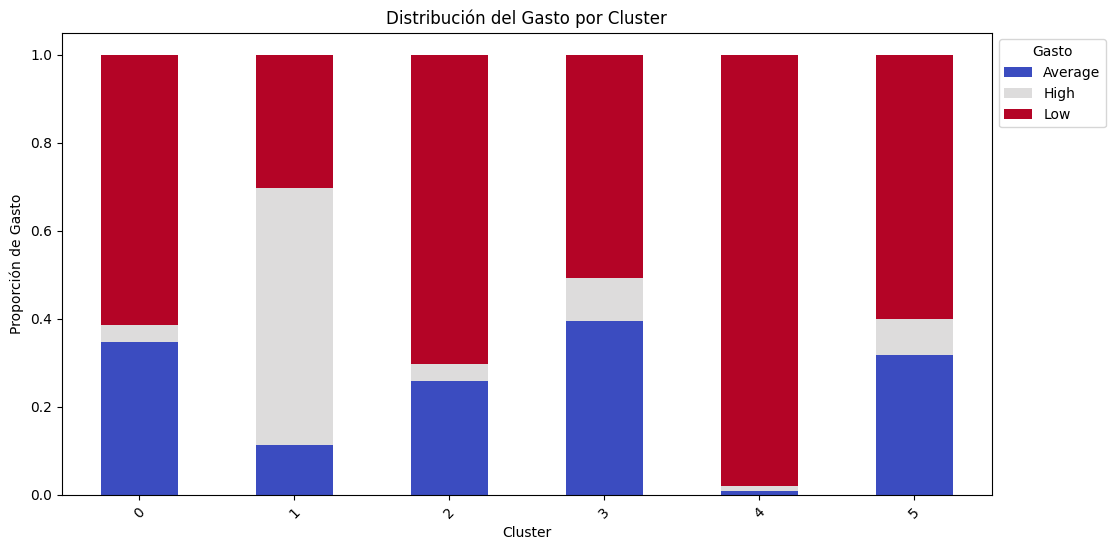

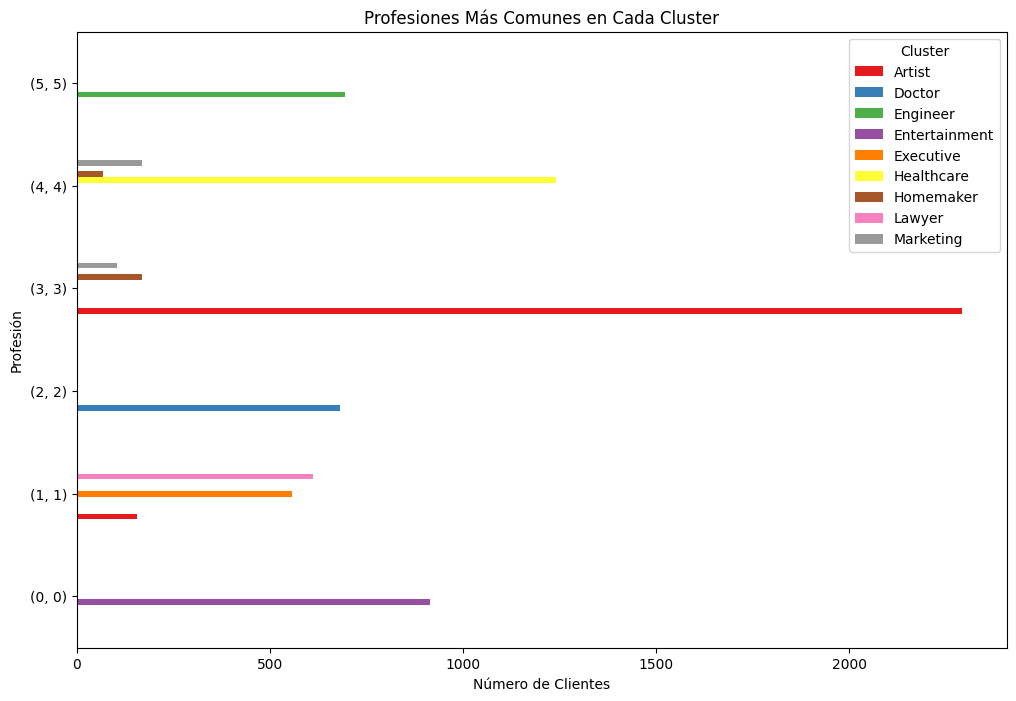

In [10]:

# ========================
# 11. Análisis de Perfiles de Clusters
# ========================

profiles = ClusteringAndMapping.analyze_cluster_profiles(df, clusters)
for profile in profiles:
    print(f"\nCluster {profile['Cluster']}:")
    print(f"Tamaño: {profile['Size']} clientes")
    print(f"Edad promedio: {profile['Avg_Age']:.1f}")
    print("Profesiones principales:")
    print(profile['Top_Professions'])
    print("Distribución de Gastos:")
    print(profile['Spending_Distribution'])

ClusteringAndMapping.analyze_feature_importance(pipeline_unsupervised, X)

# ========================
#  Gráfico: Tamaño de los Clusters
# ========================
plt.figure(figsize=(10, 5))
sns.barplot(x=df["target"].value_counts().index, y=df["target"].value_counts().values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Número de Clientes")
plt.title("Distribución del Tamaño de los Clusters")
plt.xticks(rotation=45)
plt.show()

# ========================
#  Gráfico: Distribución de Edad por Cluster
# ========================
plt.figure(figsize=(12, 6))
sns.boxplot(x="target", y="Age", data=df, palette="Set2")
plt.xlabel("Cluster")
plt.ylabel("Edad")
plt.title("Distribución de Edad por Cluster")
plt.xticks(rotation=45)
plt.show()

# ========================
#  Gráfico: Distribución de Gasto por Cluster
# ========================

# Contar distribución de gasto por cluster
gasto_por_cluster = df.groupby("target")["Spending_Score"].value_counts(normalize=True).unstack()

# Crear gráfico de barras apiladas
gasto_por_cluster.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Proporción de Gasto")
plt.title("Distribución del Gasto por Cluster")
plt.xticks(rotation=45)
plt.legend(title="Gasto", bbox_to_anchor=(1, 1))
plt.show()

# ========================
# Gráfico: Profesiones Más Comunes en Cada Cluster
# ========================

# Obtener las 3 profesiones más comunes por cluster
profesiones_por_cluster = df.groupby("target")["Profession"].value_counts().groupby(level=0).nlargest(3).unstack()

# Crear gráfico de barras horizontales
profesiones_por_cluster.plot(kind="barh", figsize=(12, 8), colormap="Set1")
plt.xlabel("Número de Clientes")
plt.ylabel("Profesión")
plt.title("Profesiones Más Comunes en Cada Cluster")
plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
plt.show()

# Interpretación de Resultados del Clustering

## Calidad del Clustering
El Silhouette Score de 0.102 es relativamente bajo (rango de -1 a 1), indicando que los clusters no están muy bien separados. Esto es común en datos del mundo real donde las características se solapan.

## Análisis por Cluster

### Cluster 0 - "Profesionales del Entretenimiento"
- **Tamaño**: 914 clientes (11.3%)
- **Perfil**: 
  * 100% trabajan en Entretenimiento
  * Edad media de 43.1 años
  * Mayoría con gastos bajos (61.5%) o medios (34.7%)
  * Características distintivas: Entretenimiento, mayoría mujeres y graduados

### Cluster 1 - "Profesionales Senior de Alto Gasto"
- **Tamaño**: 1,389 clientes (17.2%)
- **Perfil**:
  * Principalmente abogados (44%) y ejecutivos (40%)
  * Edad media alta: 66 años
  * Alto nivel de gasto (58.5%)
  * Características distintivas: Edad avanzada, solteros, profesiones de alto estatus

### Cluster 2 - "Médicos Conservadores"
- **Tamaño**: 683 clientes (8.5%)
- **Perfil**:
  * 100% doctores
  * Edad media de 37 años
  * Predominantemente gasto bajo (70.3%)
  * Características distintivas: Profesión médica, casados, graduados

### Cluster 3 - "Artistas de Gasto Moderado"
- **Tamaño**: 2,757 clientes (34.2%)
- **Perfil**:
  * Mayoría artistas (83%)
  * Edad media de 44.6 años
  * Gastos distribuidos entre bajo (50.8%) y medio (39.5%)
  * Características distintivas: No graduados, solteros, predominio masculino

### Cluster 4 - "Jóvenes Profesionales de la Salud"
- **Tamaño**: 1,629 clientes (20.2%)
- **Perfil**:
  * Principalmente sector salud (76%)
  * Muy jóvenes (26.2 años promedio)
  * Gasto predominantemente bajo (98%)
  * Características distintivas: Casados, graduados, sector salud, muy jóvenes

### Cluster 5 - "Ingenieros"
- **Tamaño**: 696 clientes (8.6%)
- **Perfil**:
  * 100% ingenieros
  * Edad media de 41.6 años
  * Mayoría gasto bajo (60%) o medio (31.8%)
  * Características distintivas: Ingenieros, hombres, graduados

## Recomendaciones de Marketing por Cluster

### 1. Cluster 1 (Alto valor)
- Enfoque en productos/servicios premium
- Programas de fidelización exclusivos
- Marketing dirigido a profesionales senior

### 2. Cluster 4 (Jóvenes profesionales)
- Productos de entrada/básicos
- Ofertas para primeras compras
- Marketing en redes sociales

### 3. Cluster 3 (Artistas)
- Productos de precio medio
- Ofertas creativas/culturales
- Marketing enfocado en valor por dinero

### 4. Clusters 0, 2, 5 (Profesionales especializados)
- Marketing segmentado por profesión
- Productos específicos para cada sector
- Programas de beneficios por sector

## MODELO SUPERVISADO

In [1]:
# ========================
# 1. Importación de librerías y carga de datos
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn y modelos
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import label_binarize

In [2]:
# ========================
# 2. Carga de los datos
# ========================
train_path = "../data/Train.csv"
test_path  = "../data/Test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Visualizar información básica (opcional)
print("Información del dataset de entrenamiento:")
print(df_train.info())
print("\nPrimeras filas:")
print(df_train.head())

Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
None

Primeras filas:
       ID  Gender Ever_Married  Age Graduated     Profession  Work_Experience  \
0  462809    Male           No   22        No     Healthcare              1.0   
1  46

In [4]:
# ========================
# 3. Definir Preprocesamiento para Clasificación
# ========================

# Definir columnas esperadas para variables numéricas y categóricas
expected_numeric = ["Age", "Work_Experience", "Family_Size"]
expected_categorical = ["Spending_score", "Gender", "Ever_Married", "Graduated", "Profession", "Var_1", "Age_Group"]

# Seleccionar columnas que están presentes en el dataset
numeric_features = [col for col in expected_numeric if col in df_train.columns]
categorical_features = [col for col in expected_categorical if col in df_train.columns]

# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar ambos en un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [5]:
# ========================
# 4. Preparar Datos de Entrenamiento y Etiquetas
# ========================

# Definir X_train eliminando columnas que no se usan (por ejemplo, ID y la etiqueta)
X_train = df_train.drop(columns=['ID', 'Segmentation'], errors='ignore')

# Definir y extraer la etiqueta
if 'target' in df_train.columns:
    # Extraer número de la etiqueta
    y_train = df_train["target"].astype(str).str.extract("(\d+)")[0].astype(int)
else:
    y_train = df_train["Segmentation"]

# Si la etiqueta es categórica (object), la codificamos
if y_train.dtype == object:
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

In [6]:
# ========================
# 5. Definir Modelos y Espacios de Hiperparámetros
# ========================

param_grids = {
    "RandomForest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [10, 20, None]
    },
    "XGBoost": {
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 6]
    },
    "LightGBM": {
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__n_estimators": [100, 200],
        "classifier__num_leaves": [31, 50]
    }
}

models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

best_models = {}

In [ ]:
# ========================
# 6. Optimización con GridSearchCV para cada modelo
# ========================
for model_name, model in models.items():
    print(f"\nOptimizando hiperparámetros para {model_name}...")
    
    # Pipeline que integra preprocesamiento y clasificador
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid_search = GridSearchCV(pipeline,
                               param_grids[model_name],
                               cv=5,
                               scoring="accuracy",
                               n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
    
import os

# Ruta base del proyecto (ajústala si es necesario)
base_dir = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/Team_Challenge_Pipelines"

# Definir la ruta de la carpeta de modelos
model_dir = os.path.join(base_dir, "src", "models")

# Asegurar que la carpeta existe (aunque ya debería existir)
os.makedirs(model_dir, exist_ok=True)

# Construir la ruta del archivo del modelo
model_path = os.path.join(model_dir, f"classification_pipeline_{model_name}.joblib")

# Guardar el modelo optimizado
joblib.dump(grid_search.best_estimator_, model_path)

print(f"Pipeline optimizada de {model_name} guardada con éxito en {model_path}.")


Mejores hiperparámetros para LightGBM: 

{'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}

Pipeline optimizada de LightGBM guardada con éxito.

In [14]:
# ========================
# 7. Evaluación del Mejor Modelo sobre Datos de Test
# ========================

# Preparar datos de test
X_test = df_test.drop(columns=['ID', 'Segmentation'], errors='ignore')
y_test = df_test["Segmentation"]

# Codificar etiqueta de test si es necesario
if y_test.dtype == object:
    le_test = LabelEncoder()
    y_test = le_test.fit_transform(y_test)

# Seleccionar, por ejemplo, el modelo de LightGBM (puedes cambiarlo según tus resultados)
best_model = best_models["LightGBM"]

# Preprocesado integrado: se aplican todas las transformaciones que se ajustaron en entrenamiento
# Se puede obtener la parte del preprocesador desde el pipeline
X_test_processed = best_model.named_steps['preprocessor'].transform(X_test)

# Realizar predicciones
y_pred = best_model.named_steps['classifier'].predict(X_test_processed)
y_pred_proba = best_model.named_steps['classifier'].predict_proba(X_test_processed)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Accuracy en test: 0.3312

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.28      0.30       846
           1       0.24      0.19      0.21       550
           2       0.26      0.34      0.30       472
           3       0.42      0.49      0.45       759

    accuracy                           0.33      2627
   macro avg       0.31      0.32      0.32      2627
weighted avg       0.33      0.33      0.33      2627



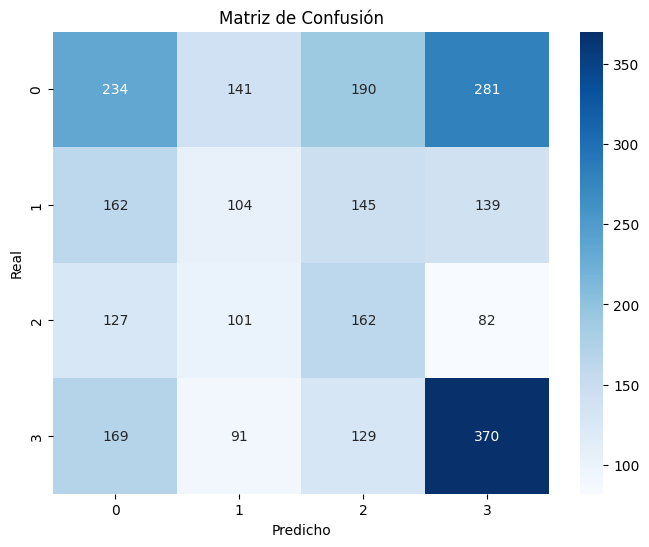

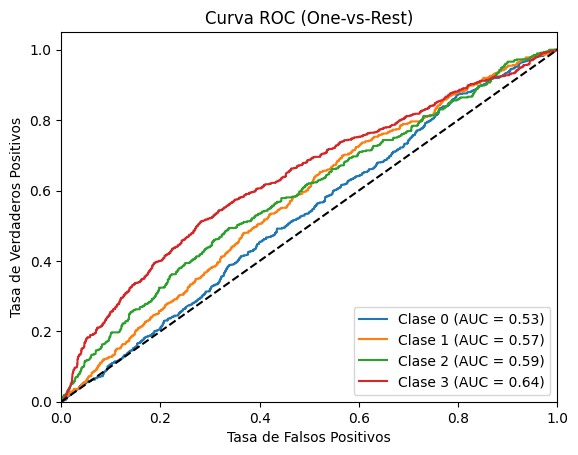

In [15]:
# ========================
# 8. Métricas de Evaluación
# ========================

# Accuracy y Classification Report
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en test: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# Curva ROC (usando One-vs-Rest para clasificación multiclase)
classes = np.unique(y_test)
n_classes = len(classes)
y_test_binarized = label_binarize(y_test, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'Clase {i} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()